In [1]:
# Load reverse_query_index, reverse ranker
# Find subset of passages that are not in train set: take the first 100 of them
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Load forward_passage_index, forward ranker
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average

In [1]:
from annoy import AnnoyIndex
import torch
import sys
import random

sys.path.insert(0, '/home/jianx/search-exposure/forward_ranker/')
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
from train import generate_sparse
from load_data import obj_reader, obj_writer
import network

from annoy import AnnoyIndex
from utils import print_message

EMBED_SIZE = 256
DEVICE = "cuda:0"
n_passage = 100
n_query = 100
rank = 100

REVERSE_INDEX_PATH = "./results/128pretrained_more_neg_query_index.ann"
REVERSE_RANKER_PATH = "./results/random_negative_pretrained_more_neg200_10_500_0.001_256_10.model"
FORWARD_INDEX_PATH = "/home/jianx/data/annoy/128_passage_index.ann"
FORWARD_RANKER_PATH = "/home/jianx/data/results/100_1000_1000_0.001_256_10.model"
PASSAGE_DICT_PATH = "/home/jianx/data/passages.dict"
QUERY_TRAIN_DICT_PATH = "/home/jianx/data/queries_train.dict"
TRAIN_RANK_PATH = "/home/jianx/data/train_data/256_20000_100_100_training.csv"
REVERSE_MAP_PATH = "./results/128pretrained_more_neg_qid_map.dict"
FORWARD_MAP_PATH = "/home/jianx/data/annoy/128_pid_map.dict"
FORWARD_QUERY_INDEX = "/home/jianx/data/annoy/128_query_index.ann"
FORWARD_QUERY_MAP = "/home/jianx/data/annoy/128_qid_map.dict"

In [2]:
def load_train(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split(",")
            pid = int(tokens[0])
            qid = int(tokens[1])
            rank = int(tokens[2].rstrip())
            if pid not in my_dict:
                my_dict[pid] = {}
            my_dict[pid][qid] = rank
            line = file.readline()
    return my_dict
def load():
    query_dict = obj_reader(QUERY_TRAIN_DICT_PATH)
    passage_dict = obj_reader(PASSAGE_DICT_PATH)
    train_rank_dict = load_train(TRAIN_RANK_PATH)
    return train_rank_dict, query_dict, passage_dict

In [3]:
import torch.nn as nn

NUM_HIDDEN_NODES = 64
NUM_HIDDEN_LAYERS = 3
DROPOUT_RATE = 0.1
FEAT_COUNT = 100000


# Define the network
class DSSM(torch.nn.Module):

    def __init__(self, embed_size):
        super(DSSM, self).__init__()

        layers = []
        last_dim = FEAT_COUNT
        for i in range(NUM_HIDDEN_LAYERS):
            layers.append(nn.Linear(last_dim, NUM_HIDDEN_NODES))
            layers.append(nn.ReLU())
            layers.append(nn.LayerNorm(NUM_HIDDEN_NODES))
            layers.append(nn.Dropout(p=DROPOUT_RATE))
            last_dim = NUM_HIDDEN_NODES
        layers.append(nn.Linear(last_dim, embed_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    def parameter_count(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [4]:
# Load reverse query index
reverse_query_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
reverse_query_index.load(REVERSE_INDEX_PATH)
# Load reverse query index mapping dict
reverse_query_map = obj_reader(REVERSE_MAP_PATH)
# Load reverse ranker model
reverse_ranker = DSSM(embed_size=EMBED_SIZE)
reverse_ranker.load_state_dict(torch.load(REVERSE_RANKER_PATH))
reverse_ranker.to(DEVICE)
reverse_ranker.eval()
# Load forward passage index
forward_passage_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
forward_passage_index.load(FORWARD_INDEX_PATH)
# Load forward passage index mapping dict 
forward_passage_map = obj_reader(FORWARD_MAP_PATH)
# Load forward ranker model
forward_ranker = network.DSSM(embed_size=EMBED_SIZE)
forward_ranker.load_state_dict(torch.load(FORWARD_RANKER_PATH))
forward_ranker.to(DEVICE)
forward_ranker.eval()
# Load train_rank, query, passage dict
train_rank_dict, query_dict, passage_dict = load()

In [5]:
# Load forward query index
forward_query_index = AnnoyIndex(EMBED_SIZE, 'euclidean')
forward_query_index.load(FORWARD_QUERY_INDEX)
# Load forward query index mapping dict 
forward_query_map = obj_reader(FORWARD_QUERY_MAP)

In [6]:
# Find subset of passages that are not in train set: take the first 100 of them
train_passage_list = set(list(train_rank_dict.keys()))
all_passage_list = set(list(passage_dict.keys()))
test_passage_list = list(all_passage_list.difference(train_passage_list))

In [7]:
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average
random_test_passage = random.sample(test_passage_list, n_passage)
# random_test_passage = random.sample(list(train_passage_list), n_passage)
counter = 0
rankings = []
total_sum = 0
match_count = 0
non_zero = []
forward_benchmark = 0
test_results_forward = {}
test_results_reverse = {}
for i, pid in enumerate(random_test_passage):
    temp_results_forward = {}
    temp_results_reverse = {}
    temp_reverse = 0
    temp_forward = 0
    print_message("Processing passage No. " + str(i+1) + "/" + str(n_passage))
    embedding = reverse_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries = reverse_query_index.get_nns_by_vector(embedding, n_query)
    embedding_forward = forward_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries_forward = forward_query_index.get_nns_by_vector(embedding_forward, n_query)
    matching_list = []
    print("Reverse:")
    for i, annoy_qid in enumerate(nearest_queries):
        qid = reverse_query_map[annoy_qid]
        top_list = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for j, annoy_pid in enumerate(top_list):
            if forward_passage_map[annoy_pid] == pid:
                print("qid {}: rank {}".format(qid,j+1))
                temp_results_reverse[qid] = j+1
                matching_list.append(j + 1)
                non_zero.append(j + 1)
                is_matched = True
                match_count += 1
                temp_reverse += 1
                break
            if not is_matched:
                matching_list.append(0)
    print("Forward:")
    for k, annoy_qid_f in enumerate(nearest_queries_forward):
        qid_f = forward_query_map[annoy_qid_f]
        top_list_f = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid_f]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for t, annoy_pid_f in enumerate(top_list_f):
            if forward_passage_map[annoy_pid_f] == pid:
                print("qid {}: rank {}".format(qid_f,t+1))
                temp_results_forward[qid_f] = t+1
                is_matched = True
                temp_forward += 1
                break
            if not is_matched:
                matching_list.append(0)    
    total_sum += sum(matching_list)
    rankings.append(matching_list)
    counter += 1
    forward_benchmark += temp_forward
    test_results_forward[pid] = temp_results_forward
    test_results_reverse[pid] = temp_results_reverse
    print("{}: Forward: {} Reverse: {}".format(pid, temp_forward, temp_reverse))
print("Forward: {} Reverse: {}".format(forward_benchmark/ n_passage, match_count / n_passage))

[Jul 23, 01:15:14] Processing passage No. 1/100
Reverse:
qid 945332: rank 50
qid 955594: rank 50
qid 617355: rank 95
qid 129922: rank 95
qid 524985: rank 95
Forward:
qid 945332: rank 50
qid 955594: rank 50
qid 617355: rank 95
qid 129922: rank 95
qid 524985: rank 95
4623438: Forward: 5 Reverse: 5
[Jul 23, 01:16:23] Processing passage No. 2/100
Reverse:
qid 66534: rank 6
qid 728393: rank 52
qid 581005: rank 38
qid 166001: rank 89
qid 396916: rank 4
qid 588634: rank 29
qid 168097: rank 14
qid 585477: rank 12
qid 666602: rank 10
qid 1164639: rank 5
qid 1061559: rank 25
qid 85908: rank 74
qid 197742: rank 23
qid 590874: rank 13
qid 583716: rank 47
qid 136560: rank 81
qid 171872: rank 10
qid 601415: rank 33
qid 666752: rank 72
qid 438382: rank 66
qid 390413: rank 17
qid 1161920: rank 69
qid 586205: rank 97
qid 810271: rank 31
qid 201210: rank 31
Forward:
qid 66534: rank 6
qid 1164639: rank 5
qid 671105: rank 7
qid 396916: rank 4
qid 588634: rank 29
qid 666602: rank 10
qid 585477: rank 12
qid

qid 140711: rank 69
qid 437561: rank 46
qid 926009: rank 99
qid 832180: rank 92
qid 995189: rank 70
qid 1072225: rank 92
6570294: Forward: 24 Reverse: 18
[Jul 23, 01:17:17] Processing passage No. 20/100
Reverse:
qid 502712: rank 52
qid 967299: rank 19
qid 259470: rank 95
qid 621090: rank 61
Forward:
qid 967299: rank 19
qid 259470: rank 95
qid 502712: rank 52
qid 621090: rank 61
3985483: Forward: 4 Reverse: 4
[Jul 23, 01:17:20] Processing passage No. 21/100
Reverse:
qid 113226: rank 95
qid 602524: rank 31
qid 602523: rank 30
qid 496367: rank 93
qid 1166831: rank 49
qid 1185618: rank 12
qid 427259: rank 26
Forward:
qid 602524: rank 31
qid 602523: rank 30
qid 1185618: rank 12
qid 1166831: rank 49
qid 113226: rank 95
qid 427259: rank 26
qid 496367: rank 93
311959: Forward: 7 Reverse: 7
[Jul 23, 01:17:22] Processing passage No. 22/100
Reverse:
qid 1033491: rank 83
qid 1033489: rank 83
Forward:
qid 1033491: rank 83
qid 1033489: rank 83
2596633: Forward: 2 Reverse: 2
[Jul 23, 01:17:25] Proces

3474523: Forward: 7 Reverse: 5
[Jul 23, 01:18:28] Processing passage No. 49/100
Reverse:
qid 376388: rank 50
qid 501184: rank 74
Forward:
qid 376513: rank 91
qid 376388: rank 50
qid 501184: rank 74
qid 892636: rank 89
4603399: Forward: 4 Reverse: 2
[Jul 23, 01:18:31] Processing passage No. 50/100
Reverse:
qid 911476: rank 21
qid 391574: rank 19
Forward:
qid 391574: rank 19
qid 69647: rank 99
qid 219422: rank 81
qid 911476: rank 21
2113338: Forward: 4 Reverse: 2
[Jul 23, 01:18:33] Processing passage No. 51/100
Reverse:
qid 150710: rank 6
qid 530483: rank 26
qid 501180: rank 36
qid 384904: rank 55
Forward:
qid 150710: rank 6
qid 530483: rank 26
qid 501180: rank 36
qid 384904: rank 55
6099022: Forward: 4 Reverse: 4
[Jul 23, 01:18:35] Processing passage No. 52/100
Reverse:
qid 353532: rank 58
Forward:
qid 353532: rank 58
8021499: Forward: 1 Reverse: 1
[Jul 23, 01:18:38] Processing passage No. 53/100
Reverse:
qid 353427: rank 22
qid 569686: rank 6
qid 850802: rank 70
Forward:
qid 569686: ra

Reverse:
Forward:
qid 968058: rank 93
6894242: Forward: 1 Reverse: 0
[Jul 23, 01:19:28] Processing passage No. 75/100
Reverse:
qid 532123: rank 35
Forward:
qid 532123: rank 35
3925338: Forward: 1 Reverse: 1
[Jul 23, 01:19:31] Processing passage No. 76/100
Reverse:
qid 75879: rank 11
Forward:
qid 75879: rank 11
qid 739491: rank 77
7951799: Forward: 2 Reverse: 1
[Jul 23, 01:19:33] Processing passage No. 77/100
Reverse:
qid 816931: rank 2
qid 412683: rank 52
qid 1065220: rank 63
Forward:
qid 816931: rank 2
qid 412683: rank 52
qid 1065220: rank 63
199809: Forward: 3 Reverse: 3
[Jul 23, 01:19:35] Processing passage No. 78/100
Reverse:
Forward:
8173756: Forward: 0 Reverse: 0
[Jul 23, 01:19:37] Processing passage No. 79/100
Reverse:
qid 1003637: rank 90
qid 1140665: rank 91
qid 83569: rank 44
qid 540635: rank 19
Forward:
qid 83569: rank 44
qid 1140665: rank 91
qid 1003637: rank 90
qid 205494: rank 52
4834361: Forward: 4 Reverse: 4
[Jul 23, 01:19:40] Processing passage No. 80/100
Reverse:
qid 

qid 841672: rank 92
qid 877260: rank 62
Forward:
qid 605112: rank 50
qid 411669: rank 62
qid 841672: rank 92
qid 877260: rank 62
4229796: Forward: 4 Reverse: 4
Forward: 6.71 Reverse: 5.01


In [8]:
# For each passage, use reverse_query_index to find top 1000 nearest queries
# Use forward_passage_index to find top k passages for each of the query, count += 1 if the passage is in top k
# Record the # of top k queries for each document 
# Plot histogram for distribution and compute the average
# random_test_passage = random.sample(test_passage_list, n_passage)
random_test_passage = random.sample(list(train_passage_list), n_passage)
counter = 0
rankings = []
total_sum = 0
match_count = 0
non_zero = []
forward_benchmark = 0
train_results_forward = {}
train_results_reverse = {}
for i, pid in enumerate(random_test_passage):
    temp_results_forward = train_rank_dict[pid]
    temp_results_reverse = {}
    temp_forward = len(temp_results_forward)
    forward_benchmark += temp_forward
    temp_reverse = 0
    print_message("Processing passage No. " + str(i+1) + "/" + str(n_passage))
    embedding = reverse_ranker(generate_sparse(passage_dict[pid]).to(DEVICE)).detach()
    nearest_queries = reverse_query_index.get_nns_by_vector(embedding, n_query)
    matching_list = []

    for i, annoy_qid in enumerate(nearest_queries):
        qid = reverse_query_map[annoy_qid]
        top_list = forward_passage_index.get_nns_by_vector(forward_ranker(generate_sparse(query_dict[qid]).to(DEVICE)).detach(),
                                                   rank)
        is_matched = False
        for j, annoy_pid in enumerate(top_list):
            if forward_passage_map[annoy_pid] == pid:
#                 print("Match!!!!! Rank: " + str(j + 1))
                temp_results_reverse[qid] = j+1
                matching_list.append(j + 1)
                non_zero.append(j + 1)
                is_matched = True
                match_count += 1
                temp_reverse += 1
                break
            if not is_matched:
                matching_list.append(0)
    total_sum += sum(matching_list)
    rankings.append(matching_list)
    counter += 1
    train_results_forward[pid] = temp_results_forward
    train_results_reverse[pid] = temp_results_reverse
    print("Reverse: {}".format(temp_results_reverse))
    print("Forward: {}".format(temp_results_forward))
    print("{}: Forward: {} Reverse: {}".format(pid, temp_forward, temp_reverse))
print("Forward: {} Reverse: {}".format(forward_benchmark/ n_passage, match_count / n_passage))

[Jul 23, 01:22:06] Processing passage No. 1/100
Reverse: {206650: 13, 629414: 37, 699790: 16, 910374: 86, 872799: 81, 622243: 16, 640363: 16, 1144230: 71, 59171: 29, 1138417: 40, 1036620: 40}
Forward: {699790: 16, 622243: 16, 640363: 16, 59171: 29, 629414: 37, 206650: 13, 910374: 86, 210776: 78, 872799: 81, 1144230: 71, 1138417: 40, 1036620: 40}
6918884: Forward: 12 Reverse: 11
[Jul 23, 01:22:07] Processing passage No. 2/100
Reverse: {949609: 29, 623778: 15, 881869: 42, 347055: 71, 386754: 18}
Forward: {623778: 15, 949609: 29, 1008238: 11, 881869: 42, 386754: 18, 347055: 71, 174983: 91, 62709: 74}
7578657: Forward: 8 Reverse: 5
[Jul 23, 01:22:09] Processing passage No. 3/100
Reverse: {56101: 78}
Forward: {56101: 78}
2067050: Forward: 1 Reverse: 1
[Jul 23, 01:22:10] Processing passage No. 4/100
Reverse: {1174662: 1, 872615: 7, 966130: 50, 236892: 18, 274914: 32, 931701: 89}
Forward: {1174662: 1, 872615: 7, 966130: 50, 236892: 18, 931701: 89, 274914: 32}
160481: Forward: 6 Reverse: 6
[Ju

Reverse: {961687: 83}
Forward: {961687: 83}
4610026: Forward: 1 Reverse: 1
[Jul 23, 01:22:43] Processing passage No. 34/100
Reverse: {1072209: 85}
Forward: {1072209: 85}
8257579: Forward: 1 Reverse: 1
[Jul 23, 01:22:44] Processing passage No. 35/100
Reverse: {129078: 16, 665970: 2, 959672: 22, 57373: 14, 124854: 8, 821373: 88, 556821: 16, 389896: 13, 931387: 13, 511145: 23, 126554: 16, 985740: 7, 128065: 6, 190958: 14, 629874: 31, 646252: 46, 970706: 36, 1171373: 36, 985739: 29, 452663: 79, 876412: 51, 646968: 16, 679531: 59, 924313: 3, 438383: 61, 1168791: 50}
Forward: {486168: 1, 519204: 6, 129078: 16, 683846: 4, 985740: 7, 433044: 15, 665970: 2, 448115: 15, 468009: 10, 389896: 13, 940614: 6, 974665: 77, 931387: 13, 970706: 36, 648352: 73, 1160536: 21, 1160535: 21, 201843: 30, 224133: 64, 132402: 55, 618607: 50, 157341: 26, 122990: 8, 224101: 43, 924313: 3, 126407: 20, 1171373: 36, 931648: 47, 985739: 29, 57373: 14, 15678: 58, 1048923: 22, 734147: 60, 1142115: 33, 118231: 41, 124854:

Reverse: {544919: 47, 254488: 41, 967169: 23, 47601: 17, 777228: 37, 465010: 20, 349041: 18, 873904: 68, 694994: 72, 1140137: 71, 28960: 86, 645388: 68, 784744: 50, 464937: 84, 726318: 74, 474645: 72, 443003: 55, 753654: 51}
Forward: {47601: 17, 967169: 23, 465010: 20, 544919: 47, 254488: 41, 349041: 18, 1140137: 71, 873904: 68, 784744: 50, 464937: 84, 443003: 55, 726318: 74, 474645: 72, 28960: 86, 777228: 37, 777216: 28, 645388: 68, 484751: 92, 694994: 72, 753654: 51, 673352: 66}
5866674: Forward: 21 Reverse: 18
[Jul 23, 01:23:15] Processing passage No. 63/100
Reverse: {70823: 68, 537549: 30, 1175552: 18, 852671: 50, 159493: 80}
Forward: {852671: 50, 70823: 68, 1175552: 18, 159493: 80, 537549: 30}
426231: Forward: 5 Reverse: 5
[Jul 23, 01:23:16] Processing passage No. 64/100
Reverse: {390050: 14, 389789: 11, 389788: 11, 910575: 8, 539185: 25, 915619: 78, 1017158: 95, 192530: 55}
Forward: {910575: 8, 539185: 25, 389789: 11, 389788: 11, 390050: 14, 1017158: 95, 192530: 55, 915619: 78}
8

Reverse: {670377: 3, 89303: 12, 764175: 66}
Forward: {89303: 12, 670377: 3, 764175: 66}
3898056: Forward: 3 Reverse: 3
[Jul 23, 01:23:49] Processing passage No. 94/100
Reverse: {582094: 1, 826747: 20, 1182230: 93, 971081: 14, 626279: 59, 459136: 11, 554184: 33, 818903: 6, 375447: 39, 763229: 55, 659928: 96, 1064337: 41, 772644: 62, 783070: 82, 1144342: 98}
Forward: {582094: 1, 971081: 14, 459136: 11, 818903: 6, 194990: 33, 375449: 26, 659928: 96, 611743: 25, 375447: 39, 554184: 33, 826747: 20, 783070: 82, 1064337: 41, 763229: 55, 615760: 61, 772644: 62, 1144342: 98, 626279: 59}
7200743: Forward: 18 Reverse: 15
[Jul 23, 01:23:50] Processing passage No. 95/100
Reverse: {897296: 20, 361369: 22, 1024693: 75}
Forward: {897296: 20, 1024693: 75, 361369: 22}
8056146: Forward: 3 Reverse: 3
[Jul 23, 01:23:51] Processing passage No. 96/100
Reverse: {153913: 80}
Forward: {153913: 80}
8106891: Forward: 1 Reverse: 1
[Jul 23, 01:23:52] Processing passage No. 97/100
Reverse: {1007234: 61, 557022: 44, 

In [22]:
# Check if reverse ranker can extract more relevant queires 
# compared to forward ranker
for pid in list(test_results_forward.keys()):   
    forward_set = set(test_results_forward[pid].values())
    reverse_set = set(test_results_reverse[pid].values())
    diff_set = reverse_set.difference(forward_set)
    if len(diff_set) != 0:
        print("pid: {} {}".format(pid, diff_set))
        print("Reverse: {}".format(test_results_reverse[pid]))
        print("Forward: {}".format(test_results_forward[pid]))
        print("____________________________________________________________________________________________________________________________")

pid: 5607392 {72}
Reverse: {66534: 6, 728393: 52, 581005: 38, 166001: 89, 396916: 4, 588634: 29, 168097: 14, 585477: 12, 666602: 10, 1164639: 5, 1061559: 25, 85908: 74, 197742: 23, 590874: 13, 583716: 47, 136560: 81, 171872: 10, 601415: 33, 666752: 72, 438382: 66, 390413: 17, 1161920: 69, 586205: 97, 810271: 31, 201210: 31}
Forward: {66534: 6, 1164639: 5, 671105: 7, 396916: 4, 588634: 29, 666602: 10, 585477: 12, 171872: 10, 590874: 13, 884039: 22, 87169: 6, 1061559: 25, 165384: 17, 85908: 74, 581005: 38, 168097: 14, 586205: 97, 584018: 85, 810271: 31, 201210: 31, 601415: 33, 728393: 52, 1161920: 69, 667561: 27, 666045: 27, 390413: 17, 665809: 33, 556232: 57, 1184259: 30, 667758: 58, 830992: 95, 583716: 47, 197742: 23, 869821: 61, 756709: 70, 166001: 89, 136560: 81, 167064: 89, 583671: 91, 71652: 59, 514677: 93, 84307: 79, 734285: 96, 438382: 66, 594979: 43, 601390: 87, 581378: 91}
__________________________________________________________________________________________________________

In [21]:
# Check if reverse ranker can extract more relevant queires 
# compared to forward ranker
for pid in list(train_results_forward.keys()):   
    forward_set = set(train_results_forward[pid].values())
    reverse_set = set(train_results_reverse[pid].values())
    diff_set = reverse_set.difference(forward_set)
    if len(diff_set) != 0:
        print("pid: {} {}".format(pid, diff_set))
        print("Reverse: {}".format(train_results_reverse[pid]))
        print("Forward: {}".format(train_results_forward[pid]))
        print("____________________________________________________________________________________________________________________________")

pid: 8360241 {88}
Reverse: {34023: 29, 102084: 40, 445095: 65, 481049: 11, 308279: 7, 32853: 88, 306370: 58, 33112: 77, 313166: 16, 894741: 75, 108343: 18}
Forward: {308279: 7, 481049: 11, 34023: 29, 313166: 16, 51506: 13, 1035: 75, 110130: 53, 445095: 65, 108343: 18, 102084: 40, 534931: 68, 112923: 90, 317267: 86, 306370: 58, 975390: 70, 190750: 76, 475122: 79, 33112: 77, 314687: 94, 894741: 75}
____________________________________________________________________________________________________________________________
pid: 3835277 {46, 79, 88, 61, 31}
Reverse: {129078: 16, 665970: 2, 959672: 22, 57373: 14, 124854: 8, 821373: 88, 556821: 16, 389896: 13, 931387: 13, 511145: 23, 126554: 16, 985740: 7, 128065: 6, 190958: 14, 629874: 31, 646252: 46, 970706: 36, 1171373: 36, 985739: 29, 452663: 79, 876412: 51, 646968: 16, 679531: 59, 924313: 3, 438383: 61, 1168791: 50}
Forward: {486168: 1, 519204: 6, 129078: 16, 683846: 4, 985740: 7, 433044: 15, 665970: 2, 448115: 15, 468009: 10, 389896: 13

In [35]:
# Queries plain text: queries.train.tsv
# Passages plain text: collection.tsv
import csv
QUERIES_TEXT_PATH = "/home/jianx/data/queries.train.tsv"
PASSAGES_TEXT_PATH = "/home/jianx/data/collection.tsv"

def load_tsv_dict(path):
    with open(path) as file:
        line = file.readline()
        my_dict = {}
        while line:
            tokens = line.split("\t")
            indexid = int(tokens[0])
            text = tokens[1].rstrip()
            my_dict[indexid] = text
            line = file.readline()
    return my_dict

In [36]:
queries_text_dict = load_tsv_dict(QUERIES_TEXT_PATH)

In [38]:
passages_text_dict = load_tsv_dict(PASSAGES_TEXT_PATH)

In [57]:
# Example:
# pid: 4834361 {19}
# Reverse: {1003637: 90, 1140665: 91, 83569: 44, 540635: 19}
# Forward: {83569: 44, 1140665: 91, 1003637: 90, 205494: 52}
# _________________________________________________________________
def display_example(pid, foward_results_all, reverse_results_all):
    passage = passages_text_dict[pid]
    forward_results = foward_results_all[pid]
    reverse_results = reverse_results_all[pid]
    forward_set = set(forward_results.keys())
    reverse_set = set(reverse_results.keys())
    diff_set = reverse_set.difference(forward_set)
    print(diff_set)
    print("Passage:")
    print(passage)
    print("--------------------------------------------------------------------------------------------------------------------------------")
    print("Forward:")
    for qid_f in list(forward_results.keys()):
        query = queries_text_dict[qid_f]
        rank = forward_results[qid_f]
        print("Rank: {} {}".format(rank, query))
    print("--------------------------------------------------------------")
    print("Reverse:")
    for qid_r in list(reverse_results.keys()):
        query = queries_text_dict[qid_r]
        rank = reverse_results[qid_r]
        if qid_r in diff_set:
            print("----New query detected by reverse ranker-----")
            print("Rank: {} {}".format(rank, query))
            print("---------------------------------------------")
        else:
            print("Rank: {} {}".format(rank, query))

In [58]:
display_example(4834361, test_results_forward, test_results_reverse)

{540635}
Passage:
If you are using NuvaRing, the vaginal contraceptive ring on an extended regimen, and you experience breakthrough bleeding or spotting [for at least 5 consecutive days], remove the ring for 4 days, store it, and then reinsert the ring.uvaRing Breakthrough Bleeding. If you are using NuvaRing, the vaginal contraceptive ring on an extended regimen, and you experience breakthrough bleeding or spotting [for at least 5 consecutive days], remove the ring for 4 days, store it, and then reinsert the ring. [Use a backup birth control method for those 4 days.].
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 44 cast of the crucible
Rank: 91 where is the crucible takes place
Rank: 90 where was the crucible setting
Rank: 52 horse war donkey peace
--------------------------------------------------------------
Reverse:
Rank: 90 where was the crucible setting
Rank: 91 where is the crucible

In [59]:
display_example(5607392, test_results_forward, test_results_reverse)

{666752}
Passage:
an induction apparatus for changing electrical energy at one voltage and current to electrical energy at another voltage and current, through the medium of magnetic energy, without mechanical motion. transformer fluid. may cause poisoning due to its polychlorinated biphenyl content.
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 6 can diverticulitis cause bloating of abdomen
Rank: 5 what causes the earth not to become larger
Rank: 7 what ingredient in strivectin causes an itching allergic reaction
Rank: 4 intense heat is a cause of body injuries
Rank: 29 what causes herpes
Rank: 10 what happens to my body when i sneeze?
Rank: 12 what causes arthritis bumps on joints
Rank: 10 does sugar cause acne
Rank: 13 what causes plantar fibromas
Rank: 22 what other term is the net income summary
Rank: 6 causes of leaking heart valves
Rank: 25 why can cocyx bone cause numbness
Rank: 17

In [60]:
 display_example(3835277, train_results_forward, train_results_reverse)

{1168791, 646252, 438383, 646968, 629874, 452663, 959672, 876412, 821373}
Passage:
For other persons named Neil Young, see Neil Young (disambiguation). Neil Percival Young, OC OM (born November 12, 1945), is a Canadian singer-songwriter, musician, producer, director and screenwriter. Young began performing in a group covering Shadows instrumentals in Canada in 1960.
--------------------------------------------------------------------------------------------------------------------------------
Forward:
Rank: 1 reconstruction finance corporation definition quizlet
Rank: 6 the trachea is made up of what tissue
Rank: 16 define wear
Rank: 4 what is a formal organization workplace
Rank: 7 where is kennewick ne
Rank: 15 jell-o meaning
Rank: 2 what happens if vapour liquids is out of date
Rank: 15 meaning of last name grieve.
Rank: 10 offense tracking number
Rank: 13 hypercarbia definition medical
Rank: 6 when did ruth wakefield die
Rank: 77 where does the name mila come from
Rank: 13 what's t

In [61]:
# A naive hypothesis:
# It seems that longer documment is less popular
# Below is the testing (count the number of words after we remove the stop words)
# Test on the train rank list

In [62]:
import matplotlib.pyplot as plt
passage_len = []
n_queries = []
for pid in list(train_rank_dict.keys()):
    n_queries.append(len(train_rank_dict[pid]))
    passage_len.append(len(passage_dict[pid]))

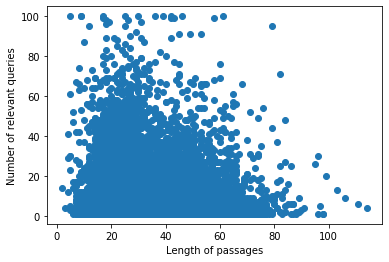

In [64]:
plt.xlabel("Length of passages")
plt.ylabel("Number of relevant queries")
plt.scatter(passage_len, n_queries)

In [65]:
# Visualize cosine similarity vs rank
# Use passage 666752 as an example

In [109]:
def compute_distance_rank(pid, forward_results, reverse_results):
    forward_distance = []
    forward_rank = []
    reverse_distance = []
    reverse_rank = []
    forward_result = forward_results[pid]
    reverse_result = reverse_results[pid]
    passage = generate_sparse(passage_dict[pid]).to(DEVICE)
    # forward embedding space
    for qid_f in list(forward_result.keys()):
        passage_f = forward_ranker(passage).unsqueeze(0).to(DEVICE)
        temp_q_f = forward_ranker(generate_sparse(query_dict[qid_f]).unsqueeze(0).to(DEVICE))
        distance_f = torch.cosine_similarity(passage_f, temp_q_f).item()
        forward_distance.append(distance_f)
        forward_rank.append(forward_result[qid_f])
        passage_f = forward_ranker(passage)
    # reverse embedding space
    for qid_r in list(reverse_result.keys()):
        passage_r = reverse_ranker(passage).unsqueeze(0).to(DEVICE)
        temp_q_r = reverse_ranker(generate_sparse(query_dict[qid_r]).unsqueeze(0).to(DEVICE))
        distance_r = torch.cosine_similarity(passage_r, temp_q_r).item()
        reverse_distance.append(distance_r)
        reverse_rank.append(reverse_result[qid_r])
    return forward_distance, forward_rank, reverse_distance, reverse_rank
    

In [110]:
forward_distance, forward_rank, reverse_distance, reverse_rank = compute_distance_rank(5607392, test_results_forward, test_results_reverse)

In [121]:
def visualize_distance_rank(pid, forward_results, reverse_results):
    forward_distance, forward_rank, reverse_distance, reverse_rank = compute_distance_rank(pid, 
                                                                    forward_results, reverse_results)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Rank")
    plt.scatter(forward_distance, forward_rank, label = "Forward Ranker")
    plt.scatter(reverse_distance, reverse_rank, label = "Reverse Ranker")
    plt.legend()
    plt.show()

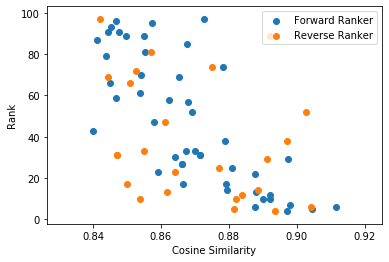

In [122]:
visualize_distance_rank(5607392, test_results_forward, test_results_reverse)

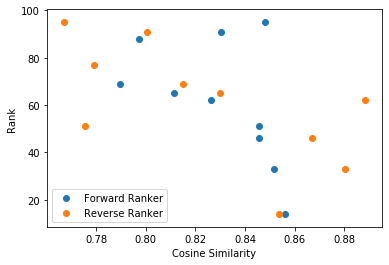

In [126]:
visualize_distance_rank(4342337, test_results_forward, test_results_reverse)

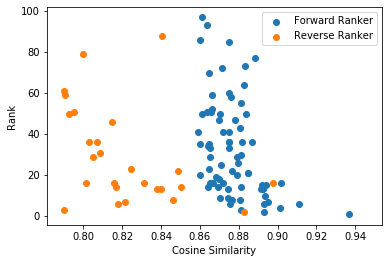

In [123]:
visualize_distance_rank(3835277, train_results_forward, train_results_reverse)

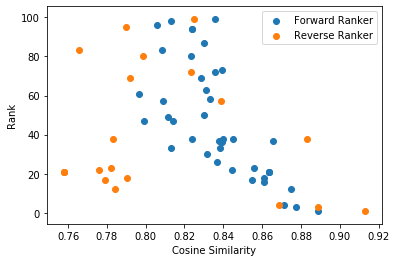

In [127]:
visualize_distance_rank(1647978, train_results_forward, train_results_reverse)